In [1]:
### import libraries
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt

# Create Temporal Sequence Data

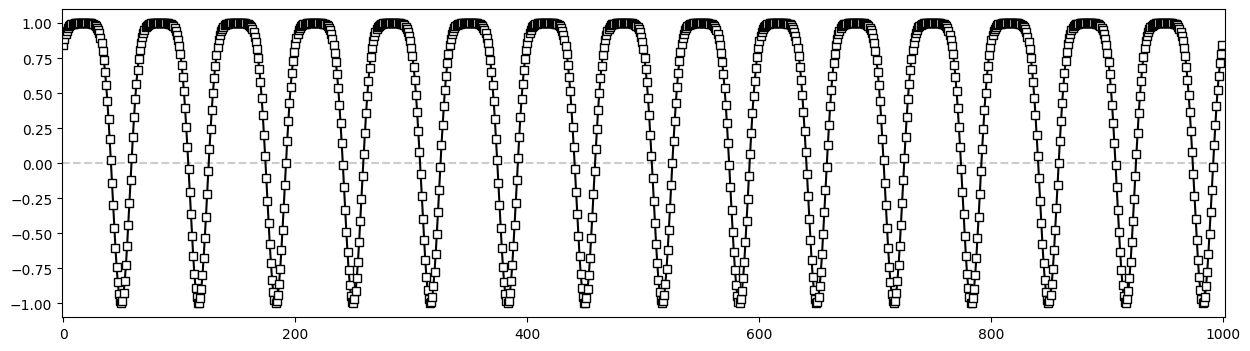

In [2]:
# import the data
N = 1000

t = torch.linspace(0,30*np.pi,N)

data = torch.sin(t + torch.cos(t))


plt.figure(figsize=(15,4))
plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data,'ks-',markerfacecolor='w')
plt.xlim([-1,N+1])
plt.show()

# Create a class for the RNN model

In [3]:
# Find the indices where the data crosses the x-axis with a positive slope
zero_crossings = torch.where((data[:-1] <= 0) & (data[1:] > 0))[0]

# Calculate the number of data points in a cycle
cycle_length = zero_crossings[1] - zero_crossings[0]

print(f"The number of data points in a cycle is: {cycle_length}")

The number of data points in a cycle is: 67


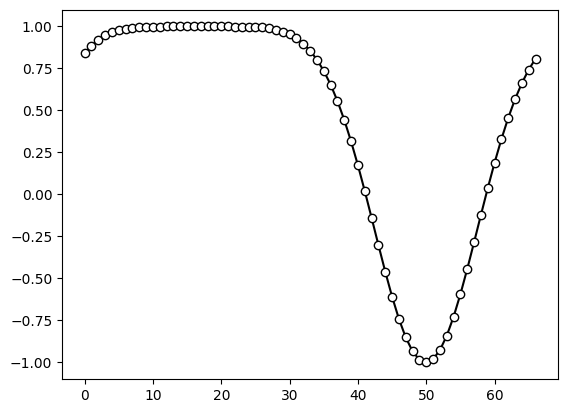

In [4]:
plt.plot(data[:cycle_length],'ko-',markerfacecolor='w')
plt.show();

In [5]:
class rnnnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)

    # linear layer for output
    self.out = nn.Linear(num_hidden,1)

  def forward(self, x):

    # run through the RNN layer
    y,hidden = self.rnn(x) # no explicit hidden state initialization

    # and the output (linear) layer
    y = self.out(y)

    return y,hidden

In [6]:
# network parameters
input_size =  1 # "channels" of data
num_hidden =  5 # breadth of model (number of units in hidden layers)
num_layers =  1 # depth of model (number of "stacks" of hidden layers)
seqlength  =  cycle_length # number of datapoints used for learning in each segment
batchsize  =  1 # Note: the training code is actually hard-coded to organize data into batchsize=1

# create an instance of the model and inspect
net = rnnnet(input_size,num_hidden,num_layers)

X = torch.rand(seqlength,batchsize,input_size)
y,h = net(X)
print(X.shape)
print(y.shape) # note: one output per sequence element; generally, we take the final output to force a "many-to-one" design.
print(h.shape)

torch.Size([67, 1, 1])
torch.Size([67, 1, 1])
torch.Size([1, 1, 5])


In [7]:
# test the model with a sample data
# test the model with some data
sample_data = torch.linspace(0,10*np.pi,N).view(-1,1)
y, _ = net(sample_data)

# grab the final predicted value from the output (first element of tuple output of net)
finalValue = y[-1]

lossfun = nn.MSELoss()
lossfun(finalValue.view(1),data[seqlength].view(1))

tensor(0.1608, grad_fn=<MseLossBackward0>)

# Train the model and evaluate

In [8]:
# number of training epochs
numepochs = 30

# create a new instance of the model (and optimizer!)
net = rnnnet(input_size,num_hidden,num_layers)
optimizer = torch.optim.SGD(net.parameters(),lr=.001)



# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over data segments
  seglosses = []
  # segacc    = []
  hidden_state = torch.zeros(num_layers,batchsize,num_hidden) # reset the hidden state on each epoch

  for timei in range(N-seqlength):

    # grab a snippet of data
    X = data[timei:timei+seqlength].view(seqlength,1,1)
    y = data[timei+seqlength].view(1,1)

    # forward pass and loss
    yHat,hidden_state = net(X)
    finalValue = yHat[-1]
    loss = lossfun(finalValue,y) # compare final value of output

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())


  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)


  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

Finished epoch 30/30

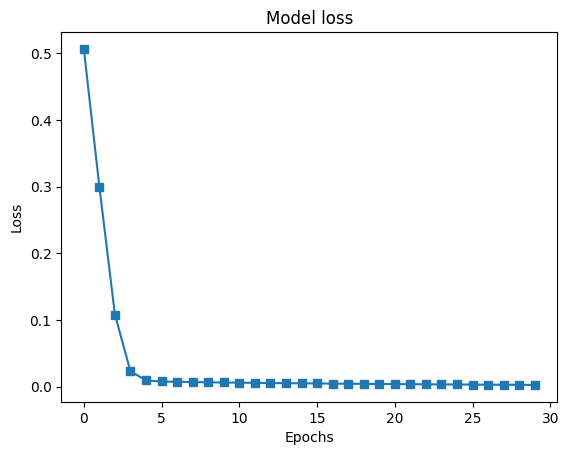

In [9]:
## let's see how the model did!


plt.plot(losses,'s-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')


plt.show()

# Test the network

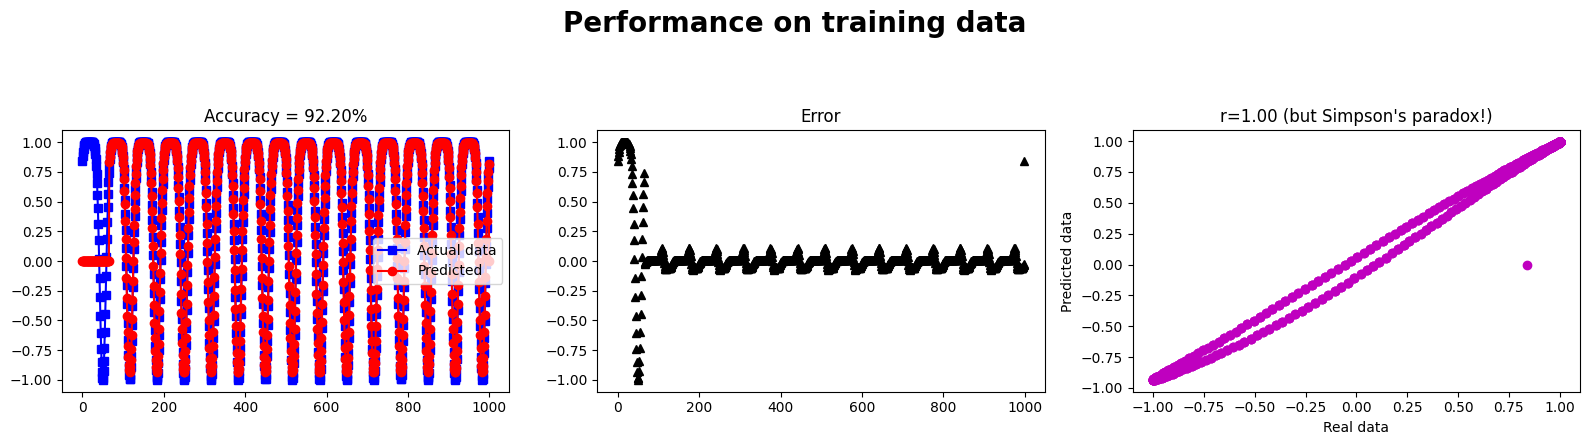

In [10]:
# initialize
N = 1000
yHat = np.zeros(N)
h    = np.zeros((N, num_hidden))
acc  = np.zeros(N, dtype=float)

for timei in range(N - seqlength):
    # snippet
    X = data[timei:timei+seqlength].view(seqlength, 1, 1)

    # forward
    yy, hh = net(X)

    # take last step prediction (make sure it's a scalar float)
    yHat_idx = timei + seqlength - 1
    yHat[yHat_idx] = yy[-1].detach().cpu().item()

    # store hidden state (ensure CPU + shape match)
    h[yHat_idx, :] = hh.detach().cpu().numpy().ravel()[:num_hidden]

    # --- accuracy for this time step ---
    # define your ground-truth aligned to the same index
    # (replace this with your actual target for that timestep)
    trueVal = np.sin(data[yHat_idx].cpu().numpy()) # Convert to numpy before applying np.sin

    # sign accuracy for this timestep (1.0 correct, 0.0 incorrect)
    acc[timei] = float(np.sign(yHat[yHat_idx]) == np.sign(trueVal))

# overall sign-accuracy (exclude NaNs if any)
Acc = 100 * np.nanmean(acc)


## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data.cpu().numpy(),'bs-',label='Actual data') # Convert to numpy for plotting
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Accuracy = %.2f%%' %Acc)
ax[0].legend()

ax[1].plot(data.cpu().numpy()-yHat,'k^') # Convert to numpy for plotting
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Error')

ax[2].plot(data[seqlength:].cpu().numpy(),yHat[seqlength:],'mo') # Convert to numpy for plotting
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:].cpu().numpy(),yHat[seqlength:]) # Convert to numpy for np.corrcoef
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

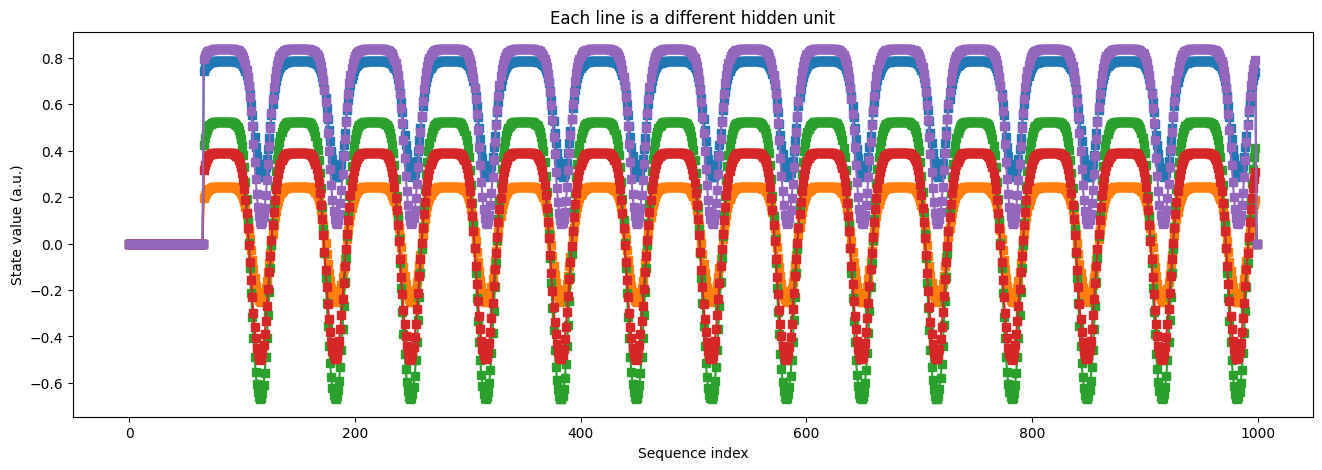

In [11]:
# show the hidden "states" (units activations)
plt.figure(figsize=(16,5))

plt.plot(h,'s-')
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a different hidden unit')
plt.show()

# Train with new data

In [12]:
# Create new data WITH FLIPPED SIGNS!
N = 1000

t = torch.linspace(0,30*torch.pi,N)

newdata = torch.sin(t + torch.sin(t))

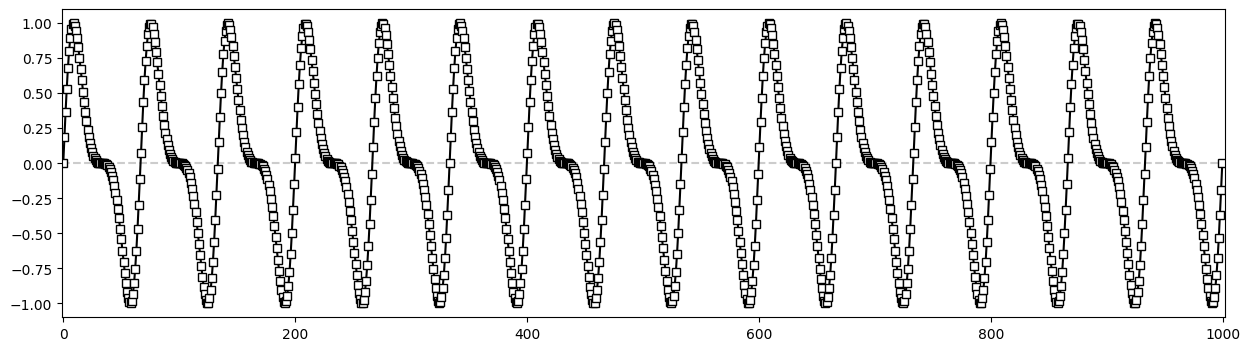

In [13]:
plt.figure(figsize=(15,4))
plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(newdata,'ks-',markerfacecolor='w')
plt.xlim([-1,N+1])
plt.show()

In [14]:
# Find the indices where the data crosses the x-axis with a positive slope
zero_crossings = torch.where((data[:-1] <= 0) & (data[1:] > 0))[0]

# Calculate the number of data points in a cycle
cycle_length = zero_crossings[1] - zero_crossings[0]

print(f"The number of data points in a cycle is: {cycle_length}")

The number of data points in a cycle is: 67


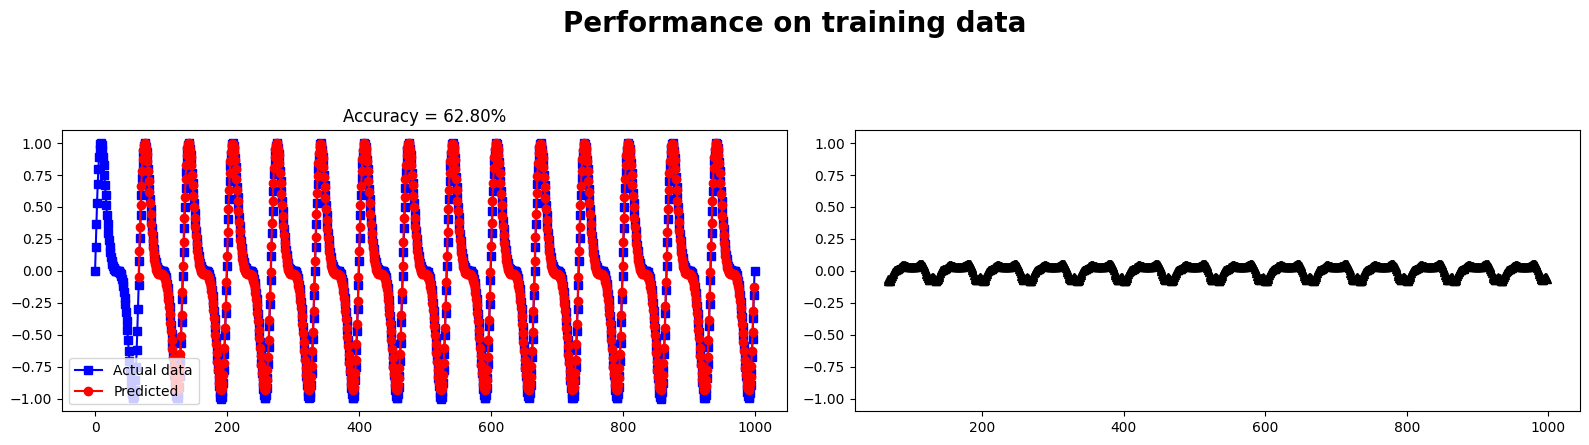

In [15]:
# initialize
N = 1000
yHat = np.full(N, np.nan)
h    = np.zeros((N, num_hidden))
acc  = np.zeros(N, dtype=float)

for timei in range(N - seqlength):
    # snippet
    X = newdata[timei:timei+seqlength].view(seqlength, 1, 1)

    # forward
    yy, hh = net(X)

    # take last step prediction (make sure it's a scalar float)
    yHat_idx = timei + seqlength - 1
    yHat[yHat_idx] = yy[-1].detach().cpu().item()

    # store hidden state (ensure CPU + shape match)
    h[yHat_idx, :] = hh.detach().cpu().numpy().ravel()[:num_hidden]

    # --- accuracy for this time step ---
    # define your ground-truth aligned to the same index
    # (replace this with your actual target for that timestep)
    trueVal = np.sin(data[yHat_idx].cpu().numpy()) # Convert to numpy before applying np.sin

    # sign accuracy for this timestep (1.0 correct, 0.0 incorrect)
    acc[timei] = float(np.sign(yHat[yHat_idx]) == np.sign(trueVal))

# overall sign-accuracy (exclude NaNs if any)
Acc = 100 * np.nanmean(acc)


## plot!
fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(newdata.cpu().numpy(),'bs-',label='Actual data') # Convert to numpy for plotting
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Accuracy = %.2f%%' %Acc)
ax[0].legend()

ax[1].plot(newdata.cpu().numpy()-yHat,'k^') # Convert to numpy for plotting
ax[1].set_ylim([-1.1,1.1])



plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

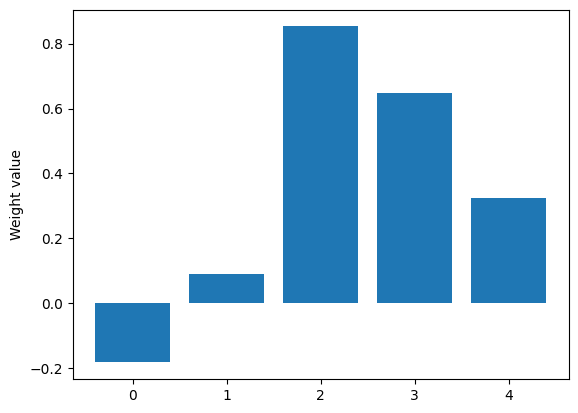

In [16]:
# plot the weights for the input->hidden layers
plt.bar(range(num_hidden),net.rnn.weight_ih_l0.detach().view(-1))
plt.ylabel('Weight value')
plt.show()